*There are no recommended prerequisites for this notebook.*

In [ ]:
# package imports (SHIFT + ENTER to run)
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# dev note : needs exercises

# Modelling (in development)

Fitting a model to data requires some metric to determine how well a model fits. This is often referred to as the *objective function* or *merit function*. These functions provide a way of measuring agreement between the model instance and data.
	 
Given a set of data points $(\boldsymbol{x},\boldsymbol{y}\pm \boldsymbol{\sigma_y})$ with Gaussian noise in the $y$ direction only, the appropriate objective function is the chi squared ($\chi^2$) function,
$$ \chi^2 = \sum_{i=1}^N \frac{\left[y_i-f(x_i|\Theta)\right]^2}{\sigma_{y_i}^2}, $$
where $\Theta$ is the set of model parameter and $f(x_i|\Theta)$ is the model evaluated at point $i$. The $\chi^2$ function is a simplified proxy that, when minimised, maximises the likelihood ($\mathcal{L}$) that the data could be generated by the specific model solution (i.e., a set of model parameters).

$\chi^2$ is related to likelihood by
$$ln\mathcal{L} = C - \frac{1}{2} \chi^2,$$
where $C$ is a constant, provided that the underlying model and the data uncertainties are the same.$\mathcal{L}$ is defined by the product of conditional probabilities;
$$\mathcal{L} = \prod_{i=1}^N P\left(y_i|x_i,\sigma_{y_i},f(x_i|\Theta)\right).$$

The frequency distribution for each data point, $y_i$, is Gaussian;
$$ P \left(y_i|x_i,\sigma_{y_i},f(x_i|\Theta)\right) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}} e^{{\frac{-1}{2} \frac{\left[y_i-f(x_i )\right]^2}{\sigma_{y_i}}}},$$
for data with Gaussian-distributed noise.

Imagine a data set is produced by the function $f(x)= 0$. The data are collected with representative uncertainties; each data uncertainty perfectly represents the random noise for an observed data point. Say we have 6 data points and there uncertainties are $\mathbf{\sigma_{y}}=(1.0, 1.2, 1.4, 1.6, 1.8, 2.0)$. The frequency distributions can be visualised as follows:

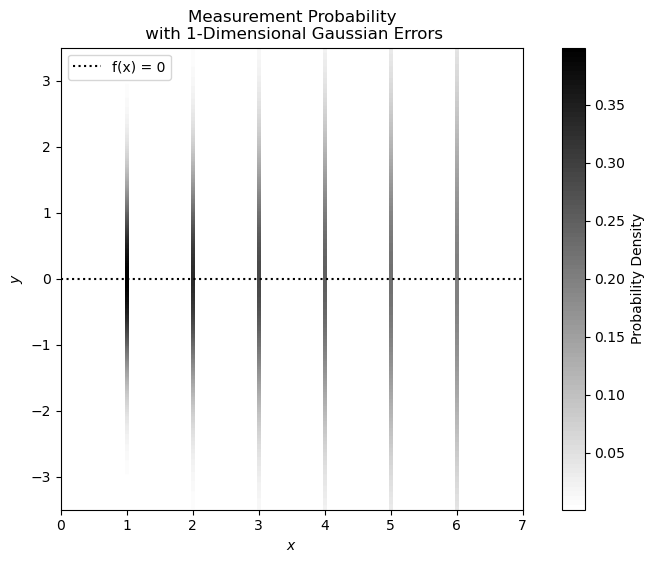

In [6]:
from matplotlib.colors import LinearSegmentedColormap
# Gaussian function to calculate frequency distribution values
def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.close(1)
plt.figure(1, figsize=(10, 6))

x = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
sigma_y = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
x_model = np.arange(8)
y_model = np.zeros_like(x_model)

# Plot vertical lines with Gaussian alpha values
y_range = np.linspace(-3.5, 3.5, 400)  # Define the range for y values

# Create a 2D array for the heatmap
heatmap = np.zeros((len(y_range), len(x)))

# Fill the heatmap with Gaussian alpha values
for i, sigma in enumerate(sigma_y):
    heatmap[:, i] = gaussian(y_range, 0, sigma)

# Create a custom colormap that goes from blue to white
colors = [(1, 1, 1), (0, 0, 0)]  # Blue to white
n_bins = 100  # Number of bins in the colormap
cmap_name = 'blue_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
width = 0.05

# Determine the min and max values for normalization
vmin = heatmap.min()
vmax = heatmap.max()

# Plot the heatmap
for i, xi in enumerate(x):
    plt.imshow(heatmap[:, i:i+1], extent=[xi - width/2, xi + width/2, y_range[0], y_range[-1]], 
               aspect='equal', cmap=cm, origin='lower', vmin=vmin, vmax=vmax)

plt.colorbar(label='Probability Density')
plt.plot(x_model, y_model, 'k:', label=r'f(x) = 0')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(0, 7)
plt.title('Measurement Probability\n with 1-Dimensional Gaussian Errors')
plt.legend(loc='upper left')
plt.show()

> <i>In the above plot, and the following plots like it, the gradiented regions are indicative of the relative probability of us measuring a given ($x$, $y$) value. The darkest regions on the plot are the most likely measurement values.</i>

But what exactly is a generative model? A generative model is a parameterised formula describing the statistical procedure for generating a given data set. Given a good generative model, the data set being fitted could reasonably be generated.  Therefore, when fitting a model, one looks for the model parameters with the highest probability of producing the data set. This happens when the likelihood is maximised, or rather $\chi^2$ is minimised.

> <i>Refer to [Hogg, Bovy & Lang (2010)](https://arxiv.org/pdf/1008.4686) for a thorough breakdown on modelling terminology, guidance, and statistical premise.</i>
	
Searching for the "best" model parameters can be done in many ways. One such method is the weighted linear regression method, described and used in the [Single Lenses](SingleLenses.ipynb) notebook, for deblending flux data. The choice of modelling method depends greatly on the data and the likelihood space.

In cases where both $x$ and $y$ uncertainties are significant, linear regression is an inappropriate choice of regression method. 2D uncertainties require 2D "distances," so orthogonal distance regression is a more appropriate choice. Colour-Colour relations between observatories are an example of fitting that uses orthogonal distance regression. See, for example, the [Spitzer]() notebook (in preperation).

Considering our earlier $f(x)=0$ model, if we give our $x$-data uncertainties of 0.35, our frequency distributions can be visualised as follows:

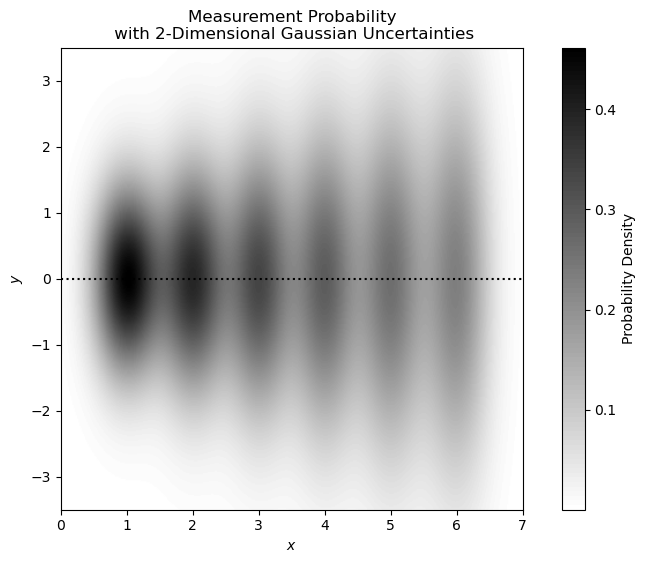

In [5]:
# Normalized 2D Gaussian function
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(-0.5 * (((x - mu_x) / sigma_x) ** 2 + ((y - mu_y) / sigma_y) ** 2))

plt.close(2)
plt.figure(2, figsize=(10, 6))

x_points = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
sigma_x = 0.35
sigma_y = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
x_model = np.arange(8)
y_model = np.zeros_like(x_model)

# Define the range for x and y values
x_range = np.linspace(0, 7, 400)
y_range = np.linspace(-3.5, 3.5, 400)
X, Y = np.meshgrid(x_range, y_range)

# Create a 2D array to hold the combined heatmap
combined_heatmap = np.zeros_like(X)

# Calculate and sum the 2D Gaussian values for each point
for i in range(6):
    Z = gaussian_2d(X, Y, x_points[i], 0.0, sigma_x, sigma_y[i])
    combined_heatmap += Z

# Create a custom colormap that goes from white to blue
colors = [(1, 1, 1), (0, 0, 0)]  # White to blue
n_bins = 100  # Number of bins in the colormap
cmap_name = 'white_blue'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the combined heatmap using imshow
plt.imshow(combined_heatmap, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], 
           aspect='equal', cmap=cm, origin='lower')

plt.colorbar(label='Probability Density')
plt.plot(x_model, y_model, 'k:', label=r'f(x) = 0')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(0, 7)
plt.title('Measurement Probability\n with 2-Dimensional Gaussian Uncertainties')
plt.show()


Were the data uncertainties negligible in both $x$ and $y$, we could use the much simpler, least-squares method to optimise our model parameters.

You may want to refer to the following videos for different explanations of these regression methods:

* [least squares]()
* [weighted least squares/ weighted linear regression](https://www.youtube.com/watch?v=4SqO-nnCDjc)
* [orthogonal distance regression](https://www.youtube.com/watch?v=zP2yvuwIQ9w) (or this video about [orthogonal distance regression with Statgraphics](https://www.youtube.com/watch?v=ajgAGF-rmtE))

Or, if you have 40 minutes to spare and want to live in the magical land of *no data measurement uncertainties*, [this](https://www.youtube.com/watch?v=eYTumjgE2IY) is a good basic overview of regression.

> <i>There are thousands of good videos on least squares regression, because this is a commonly used machine learning technique. However, for machine learning purposes, modelling algorithms are usually designed for prediction power and implementation ease, rather than being driven by statistical robustness. The methods used for machine learning purposes can tend to play fast and lose with data science best practices. Finding good resources on data science approaches to regression can be challengeing nowadays, as accessible resources have become flooded with machine learning materials. We recommend you take care when learning data science techniques from sources that are not explicitly considering scientific purposes.</i>

These examples have so far all been of a linear form. However, if the model was of a nonlinear form or we required bounds on our model parameters, the regression process would no longer be algebraic; we would require a numerical means of finding the merit function's minima. There are many methods for achieving this, and the choice of minimiser is often not of great importance for simple likelihood landscapes. 

The parameter spaces of the multi-lens models are vast and the likelihood space is turbulent, making them very computationally expensive to explore. This turbulence is borne of the sharp magnification increases around caustics; a small change in model parameters and the resulting small shifts in alignment between source and caustics can results in large changes to the magnifications experienced by the source. This makes microlensing event modelling particularly challenging for what are usually well-performing minimisation methods. For this reason, we avoid "downhill" style methods in favour of random sampling (i.e. [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method); MC). Our modelling procedures tend to involve broad grid searches to determine plausible minima regions in the likelihood space (e.g. those shown in the [Binary Lenses](BinayLenses.ipynb) notebook), followed by the use of a Markov Chain Monte Carlo (MCMC) method, seeded by the plausible-grid results, for our minimisation.

## MCMC

MCMC is a subclass of the MC method. 

MC methods use a means of generating random samples to perform simulations or integration. These methods can be used to solve deterministic problems, if the random samples are generated by a probability distribution; a prior ($P(\Theta|M)$). The meaningful result from an MC method comes not from an individual outcome, but from the statistical distribution of many samples; the posterior distribution ($P(\Theta|D, M)$).  We can rewrite Bayes' theorem to better understand the role of data, $D$, model, $M$, and model parameter sets (solutions), $\Theta$, in this method:
$$ P(\Theta|D, M) = \frac{P(D|\Theta, M) \cdot P(\Theta|M)}{P(D|M)},$$
where $P(D|\Theta, M)=\mathcal{L}$ and $P(D|M)=z$.

MCMC methods are also used to feel out the posterior distribution of a parameter through random sampling of the probability space. However, this process differs from general MC sampling in the sense that the best generative model is yet to be discovered. MCMC methods first perform a burn-in sequence to search for the most probable model parameters and then randomly sample the probability space to build the posteriors. This is where the "Markov chain" in MCMC comes in. Markov chain sampling is described as memory-less because the next step in the chain to be generated will always only be dependent on the current step. A proposed step in the parameter space will be accepted if it has a higher probability of generating the observed data than the currently accepted step, or it will be randomly accepted. This random acceptance is weighted so that the more probable steps are more likely to be randomly accepted.
	
MCMC is a beneficial method for modelling, as the inherent randomness allows for escape from the local optima that sometimes appear in stochastic algorithms. This is of great importance in the case of modelling multi-lens microlensing events, with their characteristic, poorly behaved probability space. 

There are pre-existing python packages for the implementation of MCMC methods. These are useful because the optimisation of step proposal and acceptance algorithms are non-trivial. It is easy to say the sampler randomly accepts steps, but how often should that random acceptance occur and how big should our steps be so that we explore our space efficiently. And do those things need to change adaptively throughout the fitting and posterior sampling processes.

One such python implementation of MCMC is [emcee](https://emcee.readthedocs.io/en/stable/) ([Forman-mackey, 2017]()). The algorithm employed by emcee implements a "state" of multiple "walkers." Each walker has their own MCMC chain, but the proposed steps are somewhat co-dependent between walkers. The ensemble samplings are also affine invariant by default, which is to say that the median of the proposed state is the same as the current state. The emcee package has excellent documentation and accompanying tutorials, which you can check out [here](https://emcee.readthedocs.io/en/stable/tutorials/line/).

> Refer to the [emcee documentation](https://emcee.readthedocs.io/en/stable/user/moves/) for more details on the sampling "moves."

## Nested samples

The algorithm often used for Bayesian inference of a Galactic model is Nested Sampling *cite NestedSampling*.  Nested sampling is another commonly used model fitting method in the field of astrophysics. [Feroz, Hobson, & Bridgescite (2008)](https://ui.adsabs.harvard.edu/abs/2008MNRAS.384..449F) presents the nested sampling algorithm as an efficient and robust alternative to Markov Chain Monte Carlo methods for astronomical data analyses. This fitting method is less useful for microlensing modelling because of the likelihood's stochasticity. However, it works well in the application of Galactic modelling, for which the probability distributions are smooth and well-behaved (as demonstrated in [Galactic Models](GalacticModels.ipynb) notebook). 

Nested sampling is a statistical analysis algorithm used in Bayesian modelling, particularly in the context of model selection and parameter estimation.  For example, \cite{Mukherjee2006} discusses how nested sampling can be applied to selection and inference of cosmological models. As with MCMC, nested sampling is built off of the principles of Bayes theorem. Nested sampling is also a Monte Carlo method, in that it relies on repeated random sampling to perform an integration. 

In addition to parameter estimation and inference, nested sampling gives us a framework for comparison between models for which the $\chi^2$ or $\mathcal{L}$ are not strictly comparable. The evidence,
$$ z = \int \mathcal{L}(\Theta)P(\Theta|M)d\Theta, $$
normalises the prior and likelihood terms, giving essentially a prior weighted average of the likelihood, which allows us a means by which to compare the validity of different models, based on their full posterior and not just their $\mathcal{L}$-maximising solutions, provided they are integrated over the same prior volume.

In nested sampling methods, the integral in the equation below is evaluated by breaking the prior volume up into concentric ``shells'', or high-dimensional contours, of iso-likelihood. Each shell has a probability, $\lambda_i=P(V_i)$ and a volume $dV$, and the evidence integral becomes
$$ z = \int_0^\infty P(V)dV(\lambda), $$
where $P(V)$ is the *amplitude*, $dV(\lambda)$ is the *volume*, and $P(V)dV(\lambda)$ is sometimes referred to as the *typical set*. We can also think of the amplitude term as a probability *density*, the product of the density and volume as the *mass*. When comparing models we can compare their masses. What this mass allows us to understand is not just the likelihood of our solutions, but also their frequency. z evaluates whether small best-fit solutions volumes are enough to outweigh large volumes of mediocre solutions. What we might find is, when integrating over a prior volume, that the model full of mediocre fits "defeats" (has a higher overall mass) a model with a more convincing best-fit solution; the best-fit solution may be only nominally the most likely.

This problem can be re-framed again to create something even more computationally tractable:
$$
    \begin{matrix}
        z &= \int_0^\infty X(\lambda)d\lambda \nonumber \\
        &= \int^1_0\mathcal{L}(X)dX,
    \end{matrix}
$$
where this function is normalised over a prior that encloses the parameter space of the posterior, and $X(\lambda)$, the prior volume, can be described in terms of the concentric shells of iso-likelihood:
$$ X(\lambda)\equiv\int_{\{\Theta:\mathcal{L}(\Theta)>\lambda\}}P(\Theta|M)d\Theta. $$

The sampling criteria is therefore ${\{\Theta:\mathcal{L}(\Theta)>\lambda\}}$, with an increasing bound $\lambda$. This integral can be approximated numerically by
$$ z\approx \sum\limits_{i=1}^n \mathcal{L}_i \times \Delta \hat{X}\approx \sum\limits_{i=1}^n \hat{w}_i. $$
The equivalent presentation of Bayes' theorem is $\hat{p}_i=\hat{w}_i/\hat{z}$, so the samples of this method, $\hat{w}_i$, normalised by the approximation of $\hat{z}$, recover the posteriors, for free. In original nested sampling algorithms, $z$ is of prime importance, and the posterior distribution is an optional by-product. 

The specific implementation of the nested sampling algorithm used for our Galactic model was the [Dynesty](https://dynesty.readthedocs.io/en/latest/index.html) package [Speagle (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S/abstract), named such for its use of optionally dynamic nested sampling methods. These dynamic sampling methods are of particular importance when the goal is to sample a posterior, because they are designed to sample more frequently in high-likelihood regions, but are less important when the goal is to estimate the evidence, for which integration over the whole prior volume is required.

We can leverage this algorithm to make inferences from our lightcurve fits, based on a galactic model, in a manner resembling hierarchical modelling, which, put simply, means that we feed the posteriors of our lightcurve fit in as the prior for our Galactic model fit and the samples for our inference are drawn from the posterior distribution of the lightcurve fit;
$$ P(\Phi| D)\propto P(\Phi)\int P(\Theta|\Phi)P(D|\Theta)d\Theta, $$
where $\Phi$ is the set of inferred parameters from the Galactic model; $\Phi\equiv(M_{\rm L}, D_{\rm L}, D_{\rm S}, v_{\rm L}, v_{\rm S})$.

> <i>For more on traditional hierarchical modelling, refer to [Foreman-Mackey (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...795...64F) and their presentation of a hierarchical model, fit to exoplanet catalogue data.</i>

## Future additions to this notebook, in development:
* Uncertainty rescaling
* Pruning outliers
* Gaussian process (GP) modelling
* Pixel-level decorrelation
* Bayesian information criteria (BIC)

## Next steps

If you haven't already, try the [Single Lens](SingleLens.ipynb), [Binary Lens](BinaryLens.ipynb), or [Binary Source](BinarySource.ipynb) notebook, and test out some of this theoretical knowledge.